# Prerequisites

In [310]:
import pyperclip

In [311]:
import pandas as pd
from google.oauth2 import service_account

credentials = service_account.Credentials.from_service_account_file('../keys/tg-account.json')

pd.read_gbq("""
SELECT 'test'
""", project_id='lonely-expeditions-275719', credentials=credentials)

/tmp/ipykernel_47199/3491391976.py:6: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  pd.read_gbq("""


f0_
Loading ITables v2.1.3 from the init_notebook_mode cell... (need help?)



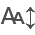

In [312]:
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)

In [313]:
from jinja2 import Template

def get_sql(sql_template, **kwargs):
    myTemplate = Template(sql_template)
    return myTemplate.render(**kwargs)

In [1184]:
start_date = '2024-05-01'
end_date = '2024-10-01'

# Query 
- Features
- Multipliers
- Rolling averages

- Calculate the tables separately
- The data is full - i don't need 

- 7 не можем использовать - придется ждать 14 дней

In [2196]:
primary_key = 'platform,tier,media_source_type,media_source'.split(',')

In [2197]:
prediction_sql = get_sql("""
CREATE OR REPLACE TABLE Temporary.TrainingDataset 
PARTITION BY (install_date)
AS

WITH dataset AS (
    SELECT 
      {{ date_field }} AS install_date,
      {{ primary_key | join(',') }},
      sum(cost) AS cost,
      sum(cost) / (SUM(total_users) + 1) AS cpi,
      SUM(total_users) AS total_users,
      {% for i in days_list %}
          sum(daily_users_{{ i }}) AS daily_users_{{ i }},
          max(payers_{{ i }}) AS payers_{{ i }},
          sum(inapp_usd_value_{{ i }})  AS inapp_usd_value_{{ i }},
          sum(inapp_usd_value_{{ i }}) / (SUM(total_users) + 1) AS inapp_usd_value_per_user_{{ i }},
          sum(ads_usd_value_{{ i }})  AS ads_usd_value_{{ i }},
          sum(ads_usd_value_{{ i }}) / (SUM(total_users) + 1) AS ads_usd_value_per_user_{{ i }},
          max(is_full_{{ i }}) AS is_full_{{ i }},
      {% endfor %}
      {% for prev_retention_day, retention_day in days_coefficients_list %}
        sum(case 
            when is_full_{{ retention_day }} 
            then total_users
        end) AS total_users_{{ prev_retention_day }}_{{ retention_day }},

        {% for field in coefficient_fields %}
            sum(case 
                when is_full_{{ retention_day }} 
                then {{ field }}_{{ prev_retention_day }}
            end) AS denominator_{{ field }}_d{{ prev_retention_day }}_{{ retention_day }},

            sum(case 
                when is_full_{{ retention_day }} 
                then {{ field }}_{{ retention_day }}
            end) AS numerator_{{ field }}_d{{ prev_retention_day }}_{{ retention_day }},

        {% endfor %}
      {% endfor %}
    FROM `Prediction.ua_cohorts_days`
    GROUP BY 
      install_date,
      {% for column in primary_key %}
          {{ column }}
          {{ ',' if not loop.last}}
      {% endfor %}
), dataset_coefficients AS (
    SELECT 
        install_date,
        {% for column in primary_key %}
            {{ column }},
        {% endfor %}
        total_users,
        {% for prev_retention_day, retention_day in days_coefficients_list %}
            {% for field in coefficient_fields %}
                CASE 
                    WHEN denominator_{{ field }}_d{{ prev_retention_day }}_{{ retention_day }} > 0.01
                        THEN numerator_{{ field }}_d{{ prev_retention_day }}_{{ retention_day }} 
                            / denominator_{{ field }}_d{{ prev_retention_day }}_{{ retention_day }} 
                        ELSE 1
                END AS multiplier_{{ field }}_d{{ prev_retention_day }}_d{{ retention_day }},
            {% endfor %}
        {% endfor %}
    FROM dataset
), dataset_coefficients_rolling AS (
    SELECT 
        window_install_date AS install_date,
        {% for column in primary_key %}
            {{ column }},
        {% endfor %}
        {% for rolling_window in rolling_windows %}
            {% for prev_retention_day, retention_day in days_coefficients_list %}
                MIN(
                    CASE
                        WHEN install_date  
                            BETWEEN window_install_date - {{ rolling_window + date_group }} - {{ retention_day }}
                            AND window_install_date - {{ date_group }} - {{ retention_day }}
                            then install_date
                    END
                ) AS min_install_date{{ field }}_d{{ prev_retention_day }}_d{{ retention_day }}_l{{ rolling_window }},
                MAX(
                    CASE
                        WHEN install_date  
                            BETWEEN window_install_date - {{ rolling_window + date_group }} - {{ retention_day }}
                            AND window_install_date - {{ date_group }} - {{ retention_day }}
                            then install_date
                    END
                ) AS max_install_date{{ field }}_d{{ prev_retention_day }}_d{{ retention_day }}_l{{ rolling_window }},
                
                {% for field in coefficient_fields %}
                    SUM(
                        CASE
                            WHEN install_date  
                                BETWEEN window_install_date - {{ rolling_window + date_group }} - {{ retention_day }}
                                AND window_install_date - {{ date_group }} - {{ retention_day }}
                                then total_users * multiplier_{{ field }}_d{{ prev_retention_day }}_d{{ retention_day }}
                        END
                    ) / (SUM(CASE
                            WHEN install_date  
                                BETWEEN window_install_date - {{ rolling_window + date_group }} - {{ retention_day }}
                                AND window_install_date - {{ date_group }} - {{ retention_day }}
                                then total_users
                        END) + 1) AS multiplier_{{ field }}_d{{ prev_retention_day }}_d{{ retention_day }}_l{{ rolling_window }},
                {% endfor %}
            {% endfor %}
        {% endfor %}
    FROM unnest(generate_date_array('{{ start_date }}', '{{ end_date }}')) window_install_date
    INNER JOIN dataset_coefficients dc
        ON dc.install_date BETWEEN window_install_date - 60 AND window_install_date - {{ date_group }}
    GROUP BY
        install_date,
        {% for column in primary_key %}
            {{ column }}
            {{ ',' if not loop.last}}
        {% endfor %}
)
SELECT *,
    EXTRACT(DAYOFWEEK FROM install_date) AS install_weekday
FROM dataset
INNER JOIN dataset_coefficients_rolling 
    USING (
        install_date,
        {% for column in primary_key %}
            {{ column }}
            {{ ',' if not loop.last}}
        {% endfor %}
    )
""", **dict(
    date_field='install_week',
    date_group=1,
    primary_key=primary_key, 
    days_list=[1, 3, 7, 14, 21, 30, 180],
    days_coefficients_list=[(1, 3), (3, 7), (7, 14), (14, 21), (21, 30)], 
    rolling_windows=[3, 7, 30],
    start_date=start_date, 
    end_date=end_date, 
    coefficient_fields=['inapp_usd_value', 'ads_usd_value']
))

In [2198]:
pyperclip.copy(prediction_sql)

In [2199]:
pd.read_gbq(prediction_sql)

/tmp/ipykernel_47199/2701526803.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  pd.read_gbq(prediction_sql)


Empty DataFrame
Columns: [install_date, platform, tier, media_source_type, media_source, cost, cpi, total_users, daily_users_1, payers_1, inapp_usd_value_1, inapp_usd_value_per_user_1, ads_usd_value_1, ads_usd_value_per_user_1, is_full_1, daily_users_3, payers_3, inapp_usd_value_3, inapp_usd_value_per_user_3, ads_usd_value_3, ads_usd_value_per_user_3, is_full_3, daily_users_7, payers_7, inapp_usd_value_7, inapp_usd_value_per_user_7, ads_usd_value_7, ads_usd_value_per_user_7, is_full_7, daily_users_14, payers_14, inapp_usd_value_14, inapp_usd_value_per_user_14, ads_usd_value_14, ads_usd_value_per_user_14, is_full_14, daily_users_21, payers_21, inapp_usd_value_21, inapp_usd_value_per_user_21, ads_usd_value_21, ads_usd_value_per_user_21, is_full_21, daily_users_30, payers_30, inapp_usd_value_30, inapp_usd_value_per_user_30, ads_usd_value_30, ads_usd_value_per_user_30, is_full_30, daily_users_180, payers_180, inapp_usd_value_180, inapp_usd_value_per_user_180, ads_usd_value_180, ads_usd_value_per_user_180, is_full_180, total_users_1_3, denominator_inapp_usd_value_d1_3, numerator_inapp_usd_value_d1_3, denominator_ads_usd_value_d1_3, numerator_ads_usd_value_d1_3, total_users_3_7, denominator_inapp_usd_value_d3_7, numerator_inapp_usd_value_d3_7, denominator_ads_usd_value_d3_7, numerator_ads_usd_value_d3_7, total_users_7_14, denominator_inapp_usd_value_d7_14, numerator_inapp_usd_value_d7_14, denominator_ads_usd_value_d7_14, numerator_ads_usd_value_d7_14, total_users_14_21, denominator_inapp_usd_value_d14_21, numerator_inapp_usd_value_d14_21, denominator_ads_usd_value_d14_21, numerator_ads_usd_value_d14_21, total_users_21_30, denominator_inapp_usd_value_d21_30, numerator_inapp_usd_value_d21_30, denominator_ads_usd_value_d21_30, numerator_ads_usd_value_d21_30, min_install_date_d1_d3_l3, max_install_date_d1_d3_l3, multiplier_inapp_usd_value_d1_d3_l3, multiplier_ads_usd_value_d1_d3_l3, min_install_date_d3_d7_l3, max_install_date_d3_d7_l3, multiplier_inapp_usd_value_d3_d7_l3, multiplier_ads_usd_value_d3_d7_l3, min_install_date_d7_d14_l3, max_install_date_d7_d14_l3, multiplier_inapp_usd_value_d7_d14_l3, multiplier_ads_usd_value_d7_d14_l3, min_install_date_d14_d21_l3, max_install_date_d14_d21_l3, multiplier_inapp_usd_value_d14_d21_l3, multiplier_ads_usd_value_d14_d21_l3, min_install_date_d21_d30_l3, max_install_date_d21_d30_l3, ...]
Index: []

[0 rows x 143 columns]

In [2200]:
revenue_df = pd.read_gbq("SELECT * FROM Temporary.TrainingDataset")

/tmp/ipykernel_47199/200507417.py:1: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  revenue_df = pd.read_gbq("SELECT * FROM Temporary.TrainingDataset")


In [2201]:
revenue_df[
    (revenue_df['tier'] == 'T0')
].sort_values('install_date', ascending=True) #.to_clipboard()

install_date platform tier media_source_type       media_source  \
87    2024-05-05      iOS   T0           Organic            organic   
84    2024-05-05  Android   T0           Organic            organic   
80    2024-05-05  Android   T0              Paid  googleadwords_int   
220   2024-05-12  Android   T0              Paid  googleadwords_int   
226   2024-05-12      iOS   T0           Organic            organic   
..           ...      ...  ...               ...                ...   
191   2024-09-22  Android   T0              Paid       Facebook Ads   
149   2024-09-29  Android   T0           Organic            organic   
148   2024-09-29      iOS   T0           Organic            organic   
146   2024-09-29  Android   T0              Paid  googleadwords_int   
138   2024-09-29  Android   T0              Paid       Facebook Ads   

          cost        cpi  total_users  daily_users_1  payers_1  ...  \
87      0.0000   0.000000          134             72         7  ...   
84      0.0000   0.000000          137             56         2  ...   
80   1599.7766   3.845617          415            165         4  ...   
220  1833.7833   4.387041          417            170         4  ...   
226     0.0000   0.000000           94             45         1  ...   
..         ...        ...          ...            ...       ...  ...   
191   312.8997  12.515988           24              9         2  ...   
149     0.0000   0.000000          262            123         3  ...   
148     0.0000   0.000000           71             21         3  ...   
146  1779.3570   4.658003          381            173         7  ...   
138   963.5107  11.750130           81             35         2  ...   

     multiplier_ads_usd_value_d7_d14_l30  min_install_date_d14_d21_l30  \
87                              1.275889                    2024-03-17   
84                              1.375276                    2024-03-17   
80                              1.198632                    2024-03-17   
220                             1.284181                    2024-03-24   
226                             1.290894                    2024-03-24   
..                                   ...                           ...   
191                             1.205992                    2024-08-04   
149                             1.267700                    2024-08-11   
148                             1.368792                    2024-08-11   
146                             1.336158                    2024-08-11   
138                             1.245538                    2024-08-11   

     max_install_date_d14_d21_l30  multiplier_inapp_usd_value_d14_d21_l30  \
87                     2024-04-07                                1.324411   
84                     2024-04-07                                1.198465   
80                     2024-04-07                                1.163064   
220                    2024-04-14                                1.158384   
226                    2024-04-14                                1.314496   
..                            ...                                     ...   
191                    2024-08-25                                1.285906   
149                    2024-09-01                                1.293986   
148                    2024-09-01                                1.204851   
146                    2024-09-01                                1.149885   
138                    2024-09-01                                1.227882   

     multiplier_ads_usd_value_d14_d21_l30  min_install_date_d21_d30_l30  \
87                               1.197868                    2024-03-10   
84                               1.214964                    2024-03-10   
80                               1.142173                    2024-03-10   
220                              1.134830                    2024-03-17   
226                              1.183294                    2024-03-17   
..                    

In [2202]:
revenue_df.isnull().sum()

install_date                               0
platform                                   0
tier                                       0
media_source_type                          0
media_source                               0
                                          ..
min_install_date_d21_d30_l30              63
max_install_date_d21_d30_l30              63
multiplier_inapp_usd_value_d21_d30_l30    63
multiplier_ads_usd_value_d21_d30_l30      63
install_weekday                            0
Length: 143, dtype: int64

# Metrics and models

- Split by train & test
- 

In [2203]:
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np

In [2204]:
import datetime as dt

In [2205]:
import numpy as np

def root_mean_squared_error(actual, predicted):
    """
    Calculate the Root Mean Square Error (RMSE) between actual and predicted values.

    Parameters:
    - actual: Array-like, true values.
    - predicted: Array-like, predicted values.

    Returns:
    - rmse: Float, the RMSE value.
    """
    actual = np.array(actual)
    predicted = np.array(predicted)
    
    # Check if lengths match
    if len(actual) != len(predicted):
        raise ValueError("The length of actual and predicted arrays must be the same.")
    
    # Calculate RMSE
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    return rmse


In [2206]:
import numpy as np

def root_mean_squared_percentage_error(actual, predicted):
    """
    Calculate the Root Mean Square Percentage Error (RMSPE) between actual and predicted values,
    ignoring NaN and zero actual values.

    Parameters:
    - actual: Array-like, true values.
    - predicted: Array-like, predicted values.

    Returns:
    - rmspe: Float, the RMSPE value as a percentage.
    """
    actual = np.array(actual, dtype=np.float64)
    predicted = np.array(predicted, dtype=np.float64)
    
    # Ensure lengths match
    if len(actual) != len(predicted):
        raise ValueError("The length of actual and predicted arrays must be the same.")
    
    # Mask NaN and zero actual values (to avoid division by zero)
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted) & (actual != 0)
    actual = actual[valid_mask]
    predicted = predicted[valid_mask]
    
    # Calculate RMSPE
    percentage_errors = ((actual - predicted) / actual) ** 2
    rmspe = np.sqrt(np.mean(percentage_errors)) * 100
    return rmspe


In [2207]:
target_day = 30
start_day = 3

In [2208]:
feature_blacklist = []

for feature in revenue_df.columns:
    try:
        value = int(feature.split('_')[-1])
        if value > start_day:
            feature_blacklist.append(feature)
    except:
        pass

In [2209]:
X = revenue_df.drop(columns=feature_blacklist)

In [2210]:
y = revenue_df[f'ads_usd_value_{target_day}']

In [2211]:
def train_test_split_by_date(X, y, split_date):
    train_indices = X['install_date'] <= split_date
    X_train = X[train_indices]
    X_test = X[~train_indices]
    
    y_train = y[train_indices]
    y_test = y[~train_indices]

    return X_train, y_train, X_test, y_test

# 

In [2212]:
model_data_X_df = X.copy()

In [2213]:
window = 7
X['ads_usd_value_predicted_30'] =  X[f'ads_usd_value_3'] * (
        X[f'multiplier_ads_usd_value_d3_d7_l{window}'].fillna(1) 
        * X[f'multiplier_ads_usd_value_d7_d14_l{window}'].fillna(1) 
        * X[f'multiplier_ads_usd_value_d14_d21_l{window}'].fillna(1) 
        * X[f'multiplier_ads_usd_value_d21_d30_l{window}'].fillna(1) 
    )

X['inapp_usd_value_predicted_30'] =  X[f'inapp_usd_value_3'] * (
        X[f'multiplier_inapp_usd_value_d3_d7_l{window}'].fillna(1) 
        * X[f'multiplier_inapp_usd_value_d7_d14_l{window}'].fillna(1) 
        * X[f'multiplier_inapp_usd_value_d14_d21_l{window}'].fillna(1) 
        * X[f'multiplier_inapp_usd_value_d21_d30_l{window}'].fillna(1) 
    )

In [2214]:
root_mean_squared_error(y, y)

0.0

In [2215]:
def predict_by_fresh_coefficients(X, y=None, window=3):
    ads_predict = X[f'ads_usd_value_3'] * (
        X[f'multiplier_ads_usd_value_d3_d7_l{window}'].fillna(1) 
        * X[f'multiplier_ads_usd_value_d7_d14_l{window}'].fillna(1) 
        * X[f'multiplier_ads_usd_value_d14_d21_l{window}'].fillna(1) 
        * X[f'multiplier_ads_usd_value_d21_d30_l{window}'].fillna(1) 
    )

    return ads_predict

In [2216]:
[c for c in X.columns if 'multiplier_inapp_usd_value_d7_d14' in c]

['multiplier_inapp_usd_value_d7_d14_l3',
 'multiplier_inapp_usd_value_d7_d14_l7',
 'multiplier_inapp_usd_value_d7_d14_l30']

In [2217]:
# def predict_by_coefficients(X, y=None, window=3, start_day=start_day):
#     ads_predict = X[f'ads_usd_value_7'] * X[f'multiplier_ads_usd_value_d7_d30_l{window}'].fillna(1)
#     inapp_predict = X[f'inapp_usd_value_7'] * X[f'multiplier_inapp_usd_value_d7_d30_l{window}'].fillna(1)

#     return inapp_predict

In [2218]:
X.columns

Index(['install_date', 'platform', 'tier', 'media_source_type', 'media_source',
       'cost', 'cpi', 'total_users', 'daily_users_1', 'payers_1',
       'inapp_usd_value_1', 'inapp_usd_value_per_user_1', 'ads_usd_value_1',
       'ads_usd_value_per_user_1', 'is_full_1', 'daily_users_3', 'payers_3',
       'inapp_usd_value_3', 'inapp_usd_value_per_user_3', 'ads_usd_value_3',
       'ads_usd_value_per_user_3', 'is_full_3', 'total_users_1_3',
       'denominator_inapp_usd_value_d1_3', 'numerator_inapp_usd_value_d1_3',
       'denominator_ads_usd_value_d1_3', 'numerator_ads_usd_value_d1_3',
       'min_install_date_d1_d3_l3', 'max_install_date_d1_d3_l3',
       'multiplier_inapp_usd_value_d1_d3_l3',
       'multiplier_ads_usd_value_d1_d3_l3', 'min_install_date_d3_d7_l3',
       'max_install_date_d3_d7_l3', 'multiplier_inapp_usd_value_d3_d7_l3',
       'multiplier_ads_usd_value_d3_d7_l3', 'min_install_date_d7_d14_l3',
       'max_install_date_d7_d14_l3', 'multiplier_inapp_usd_value_d7_d14_l

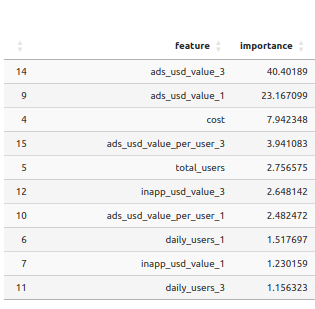

In [2220]:
def process_features_catboost(X):
    features_whitelist = [
        'cost', 
        'total_users', 
        'ads_usd_value_3', 'ads_usd_value_1', 
        'inapp_usd_value_3', 'inapp_usd_value_1', 
        'daily_users_1', 'daily_users_3',
        'payers_1', 'payers_3',
        'install_weekday',

        'ads_usd_value_predicted_30', 'inapp_usd_value_predicted_30',

        'platform', 'tier', 'media_source_type', 'media_source'
    ]
    # for field in X.columns:
    #     if field in features_whitelist:
    #         continue

    #     if 'numerator_' in field:
    #         continue
    #     if 'denominator_' in field:
    #         continue
            
    #     if any([x for x in [
    #         'multiplier_',
    #         'daily_users_',
    #         'usd_value'
    #     ] if x in field]):
    #         features_whitelist.append(field)
    #         continue

    return X[features_whitelist]

Нужно получить список дат для всех версий - раскатка T0 с мая

In [2222]:
def predict_catboost(X, y, split_date=dt.date(2024, 8, 1), debug=False):
    X_train, y_train, X_test, y_test = train_test_split_by_date(X, y, split_date)
    X_train = process_features_catboost(X_train)
    X_test = process_features_catboost(X_test)
    X_all = process_features_catboost(X)

    model = CatBoostRegressor(
        iterations=10000,
        learning_rate=0.001,
        depth=len(primary_key) + 1,
        loss_function='RMSE',
        eval_metric='RMSE',
        verbose=100,
        cat_features=['platform', 'tier', 'media_source_type', 'media_source']
    )

    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        use_best_model=True,
        plot=debug  # Set to False if you do not want a training plot
    )

    inapp_predict = model.predict(X_all)
    # rmse = mean_squared_error(y_test, y_pred, squared=False)

    if debug:
        return model, inapp_predict, X_train, X_test
    return inapp_predict

In [2223]:
model, predict, X_train, X_test = predict_catboost(X, y, debug=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 157.9258933	test: 143.8924873	best: 143.8924873 (0)	total: 1.48ms	remaining: 14.8s
100:	learn: 147.4822788	test: 133.9461151	best: 133.9461151 (100)	total: 85.3ms	remaining: 8.36s
200:	learn: 137.9518826	test: 124.9352390	best: 124.9352390 (200)	total: 154ms	remaining: 7.52s
300:	learn: 129.0648375	test: 116.5187172	best: 116.5187172 (300)	total: 238ms	remaining: 7.66s
400:	learn: 120.8234015	test: 108.9341576	best: 108.9341576 (400)	total: 320ms	remaining: 7.66s
500:	learn: 113.3381207	test: 101.8413821	best: 101.8413821 (500)	total: 383ms	remaining: 7.26s
600:	learn: 106.3244719	test: 95.3725836	best: 95.3725836 (600)	total: 455ms	remaining: 7.11s
700:	learn: 99.9137212	test: 89.5192201	best: 89.5192201 (700)	total: 522ms	remaining: 6.92s
800:	learn: 93.9923422	test: 84.1177591	best: 84.1177591 (800)	total: 586ms	remaining: 6.72s
900:	learn: 88.4604280	test: 79.1751127	best: 79.1751127 (900)	total: 653ms	remaining: 6.6s
1000:	learn: 83.4644419	test: 74.8183751	best: 74.8183

In [2224]:
X_test

cost  total_users  ads_usd_value_3  ads_usd_value_1  \
20      0.0000          222       113.882425        72.118141   
21    347.2458           79         2.857025         1.766593   
22   1457.6876          419       155.628776       106.950944   
23      0.0000          128         6.013132         3.583957   
24      0.0000          214       110.148366        75.610487   
..         ...          ...              ...              ...   
457     0.0000           98        10.196019         7.421871   
458  1340.1561           42        19.915743        12.308855   
459   149.6349           10         3.764620         3.151612   
460   240.7736          359        13.798633         9.749152   
461     0.0000            0         0.000000         0.000000   

     inapp_usd_value_3  inapp_usd_value_1  daily_users_1  daily_users_3  \
20          259.130000         113.310000            110             55   
21            0.000000           0.000000             27             14   
22          240.060000          92.320000            202            127   
23           40.343414          22.228006             53             32   
24          189.580000         138.210000            102             61   
..                 ...                ...            ...            ...   
457          31.484279          27.036874             43             25   
458           5.066799           3.828760             19              9   
459           3.338898           3.338898              4              1   
460          72.959424          65.642864            142             82   
461           0.000000           0.000000              0              0   

     payers_1  payers_3  install_weekday  ads_usd_value_predicted_30  \
20          4         4                1                  271.374094   
21          0         0                1                    4.728339   
22          3         5                1                  449.123288   
23          1         1                1                   11.247929   
24          4         4                1                  250.976110   
..        ...       ...              ...                         ...   
457         1         1                1                   21.042931   
458         1         1                1                    0.000000   
459         1         1                1                    0.000000   
460         1         1                1                   30.369362   
461         0         0                1                    0.000000   

     inapp_usd_value_predicted_30 platform tier media_source_type  \
20                    1073.628094      iOS   T0           Organic   
21                       0.000000  Android   T3              Paid   
22                     672.299516  Android   T0              Paid   
23                      41.831439      iOS   T3           Organic   
24                     857.499714  Android   T0           Organic   
..                            ...      ...  ...               ...   
457                    142.380670      iOS   T2           Organic   
458                      0.000000      iOS   T1              Paid   
459                      0.000000      iOS   T2              Paid   
460                    171.843677  Android   T3              Paid   
461                      0.000000  Android   T1              Paid   

          media_source  
20             organic  
21        Facebook Ads  
22   googleadwords_int  
23             organic  
24             organic  
..                 ...  
457            organic  
458       Facebook Ads  
459       Facebook Ads  
460  googleadwords_int  
461       applovin_int  

[240 rows x 17 columns]

In [2225]:
importances = model.get_feature_importance()
columns = X_test.columns

df = pd.DataFrame()
df['feature'] = columns
df['importance'] = importances

In [2226]:
df.sort_values('importance', ascending=False)

feature  importance
2                ads_usd_value_3   27.159596
11    ads_usd_value_predicted_30   19.598003
3                ads_usd_value_1   19.230378
14                          tier    7.468317
0                           cost    6.866530
1                    total_users    2.922336
9                       payers_3    2.908613
7                  daily_users_3    2.735347
6                  daily_users_1    2.337167
4              inapp_usd_value_3    2.075920
5              inapp_usd_value_1    2.030476
8                       payers_1    1.671852
12  inapp_usd_value_predicted_30    1.471595
13                      platform    0.758091
16                  media_source    0.757357
15             media_source_type    0.008421
10               install_weekday    0.000000

In [2227]:
# y_pred = predict_by_fresh_coefficients(X)

In [2228]:
# y_pred = predict_catboost(X, y)

In [2229]:
model_data_X_df['predict_target'] = y

In [2230]:
full_model_data = []

for model_name_template, (predict_function, model_params) in {
    # 'simple_{window}': (predict_by_coefficients, [
    #     {'window': 7}, 
    #     {'window': 30}
    # ]),
    'simple_fresh_{window}': (predict_by_fresh_coefficients, [
        {'window': 3},
        {'window': 7}, 
        {'window': 30}
    ]),
    'catboost_{split_date}': (predict_catboost, [
        {"split_date": dt.date(2024, 7, 1)}, 
        {"split_date": dt.date(2024, 8, 1)}, 
        {"split_date": dt.date(2024, 9, 1)}
    ]),
}.items():
    for params in model_params:
        model_data_X_df = X.copy()
        model_name = model_name_template.format(**params)
        
        y_pred = predict_function(X, y, **params)
        
        print(f'Params: {params}')
        print("RMSPE: ", root_mean_squared_percentage_error(y, y_pred))
        print("Error quantiles: ")
        print((np.abs(y_pred - y) / y).quantile([0.1, 0.25, 0.5, 0.75, 0.9]))
        print('-------------------------------------')
        model_data_X_df['target'] = y
        model_data_X_df['predict'] = y_pred

        model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(
            f"Temporary.aggregated_prediction_{ model_name }", if_exists="replace", table_schema=[
            {'name': 'install_date',  'type': 'DATE'}
        ])

Params: {'window': 3}
RMSPE:  55.273600612005936
Error quantiles: 
0.10    0.369348
0.25    0.493848
0.50    0.557016
0.75    0.613951
0.90    0.664255
dtype: float64
-------------------------------------


/tmp/ipykernel_47199/4270783246.py:33: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4544.21it/s]
/tmp/ipykernel_47199/4270783246.py:33: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(


Params: {'window': 7}
RMSPE:  114.0453459067575
Error quantiles: 
0.10    0.033503
0.25    0.074666
0.50    0.171763
0.75    0.339509
0.90    0.630602
dtype: float64
-------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4080.06it/s]
/tmp/ipykernel_47199/4270783246.py:33: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(


Params: {'window': 30}
RMSPE:  49.82171479175867
Error quantiles: 
0.10    0.024669
0.25    0.063067
0.50    0.150746
0.75    0.307498
0.90    0.578473
dtype: float64
-------------------------------------


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18157.16it/s]


0:	learn: 156.4362086	test: 148.9527038	best: 148.9527038 (0)	total: 2.17ms	remaining: 21.7s
100:	learn: 147.3176929	test: 139.7963398	best: 139.7963398 (100)	total: 72.5ms	remaining: 7.1s
200:	learn: 138.7836325	test: 131.3139183	best: 131.3139183 (200)	total: 141ms	remaining: 6.86s
300:	learn: 130.9853602	test: 123.7551972	best: 123.7551972 (300)	total: 211ms	remaining: 6.79s
400:	learn: 123.7652102	test: 116.6106383	best: 116.6106383 (400)	total: 271ms	remaining: 6.49s
500:	learn: 117.0424445	test: 109.9980683	best: 109.9980683 (500)	total: 331ms	remaining: 6.28s
600:	learn: 110.7763193	test: 104.0892663	best: 104.0892663 (600)	total: 405ms	remaining: 6.34s
700:	learn: 104.9117534	test: 98.5953087	best: 98.5953087 (700)	total: 472ms	remaining: 6.27s
800:	learn: 99.5152858	test: 93.6365478	best: 93.6365478 (800)	total: 534ms	remaining: 6.13s
900:	learn: 94.5727519	test: 89.1709579	best: 89.1709579 (900)	total: 589ms	remaining: 5.95s
1000:	learn: 89.9102118	test: 85.0239894	best: 85.0

/home/snail/Documents/guli/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_47199/4270783246.py:33: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 26051.58it/s]


0:	learn: 157.9258933	test: 143.8924873	best: 143.8924873 (0)	total: 5.08ms	remaining: 50.8s
100:	learn: 147.4822788	test: 133.9461151	best: 133.9461151 (100)	total: 86ms	remaining: 8.43s
200:	learn: 137.9518826	test: 124.9352390	best: 124.9352390 (200)	total: 165ms	remaining: 8.04s
300:	learn: 129.0648375	test: 116.5187172	best: 116.5187172 (300)	total: 251ms	remaining: 8.1s
400:	learn: 120.8234015	test: 108.9341576	best: 108.9341576 (400)	total: 332ms	remaining: 7.96s
500:	learn: 113.3381207	test: 101.8413821	best: 101.8413821 (500)	total: 413ms	remaining: 7.83s
600:	learn: 106.3244719	test: 95.3725836	best: 95.3725836 (600)	total: 585ms	remaining: 9.14s
700:	learn: 99.9137212	test: 89.5192201	best: 89.5192201 (700)	total: 665ms	remaining: 8.82s
800:	learn: 93.9923422	test: 84.1177591	best: 84.1177591 (800)	total: 749ms	remaining: 8.6s
900:	learn: 88.4604280	test: 79.1751127	best: 79.1751127 (900)	total: 845ms	remaining: 8.53s
1000:	learn: 83.4644419	test: 74.8183751	best: 74.8183751

/home/snail/Documents/guli/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_47199/4270783246.py:33: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 3504.01it/s]


0:	learn: 152.8310188	test: 145.7638026	best: 145.7638026 (0)	total: 1.33ms	remaining: 13.3s
100:	learn: 142.0039189	test: 134.5744987	best: 134.5744987 (100)	total: 102ms	remaining: 9.95s
200:	learn: 132.1225048	test: 124.4509492	best: 124.4509492 (200)	total: 209ms	remaining: 10.2s
300:	learn: 123.0121624	test: 115.2758936	best: 115.2758936 (300)	total: 308ms	remaining: 9.91s
400:	learn: 114.6887517	test: 106.9989332	best: 106.9989332 (400)	total: 382ms	remaining: 9.14s
500:	learn: 106.9757543	test: 99.3095607	best: 99.3095607 (500)	total: 459ms	remaining: 8.7s
600:	learn: 99.9515810	test: 92.4339439	best: 92.4339439 (600)	total: 533ms	remaining: 8.34s
700:	learn: 93.4761063	test: 86.1978206	best: 86.1978206 (700)	total: 614ms	remaining: 8.15s
800:	learn: 87.5437153	test: 80.5376382	best: 80.5376382 (800)	total: 710ms	remaining: 8.15s
900:	learn: 82.0537276	test: 75.2812493	best: 75.2812493 (900)	total: 814ms	remaining: 8.22s
1000:	learn: 77.0535413	test: 70.6529036	best: 70.6529036 

/home/snail/Documents/guli/venv/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/tmp/ipykernel_47199/4270783246.py:33: FutureWarning: to_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.to_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.to_gbq
  model_data_X_df[primary_key + ['install_date', 'predict']].to_gbq(
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13797.05it/s]


In [2151]:
model_data_X_df[
    model_data_X_df['predict'].isnull()
]

Empty DataFrame
Columns: [install_date, platform, tier, media_source_type, media_source, campaign, cost, cpi, total_users, daily_users_1, payers_1, inapp_usd_value_1, inapp_usd_value_per_user_1, ads_usd_value_1, ads_usd_value_per_user_1, is_full_1, daily_users_3, payers_3, inapp_usd_value_3, inapp_usd_value_per_user_3, ads_usd_value_3, ads_usd_value_per_user_3, is_full_3, total_users_1_3, denominator_inapp_usd_value_d1_3, numerator_inapp_usd_value_d1_3, denominator_ads_usd_value_d1_3, numerator_ads_usd_value_d1_3, min_install_date_d1_d3_l3, max_install_date_d1_d3_l3, multiplier_inapp_usd_value_d1_d3_l3, multiplier_ads_usd_value_d1_d3_l3, min_install_date_d3_d7_l3, max_install_date_d3_d7_l3, multiplier_inapp_usd_value_d3_d7_l3, multiplier_ads_usd_value_d3_d7_l3, min_install_date_d7_d14_l3, max_install_date_d7_d14_l3, multiplier_inapp_usd_value_d7_d14_l3, multiplier_ads_usd_value_d7_d14_l3, min_install_date_d14_d21_l3, max_install_date_d14_d21_l3, multiplier_inapp_usd_value_d14_d21_l3, multiplier_ads_usd_value_d14_d21_l3, min_install_date_d21_d30_l3, max_install_date_d21_d30_l3, multiplier_inapp_usd_value_d21_d30_l3, multiplier_ads_usd_value_d21_d30_l3, min_install_date_d1_d3_l7, max_install_date_d1_d3_l7, multiplier_inapp_usd_value_d1_d3_l7, multiplier_ads_usd_value_d1_d3_l7, min_install_date_d3_d7_l7, max_install_date_d3_d7_l7, multiplier_inapp_usd_value_d3_d7_l7, multiplier_ads_usd_value_d3_d7_l7, min_install_date_d7_d14_l7, max_install_date_d7_d14_l7, multiplier_inapp_usd_value_d7_d14_l7, multiplier_ads_usd_value_d7_d14_l7, min_install_date_d14_d21_l7, max_install_date_d14_d21_l7, multiplier_inapp_usd_value_d14_d21_l7, multiplier_ads_usd_value_d14_d21_l7, min_install_date_d21_d30_l7, max_install_date_d21_d30_l7, multiplier_inapp_usd_value_d21_d30_l7, multiplier_ads_usd_value_d21_d30_l7, min_install_date_d1_d3_l30, max_install_date_d1_d3_l30, multiplier_inapp_usd_value_d1_d3_l30, multiplier_ads_usd_value_d1_d3_l30, min_install_date_d3_d7_l30, max_install_date_d3_d7_l30, multiplier_inapp_usd_value_d3_d7_l30, multiplier_ads_usd_value_d3_d7_l30, min_install_date_d7_d14_l30, max_install_date_d7_d14_l30, multiplier_inapp_usd_value_d7_d14_l30, multiplier_ads_usd_value_d7_d14_l30, min_install_date_d14_d21_l30, max_install_date_d14_d21_l30, multiplier_inapp_usd_value_d14_d21_l30, multiplier_ads_usd_value_d14_d21_l30, min_install_date_d21_d30_l30, max_install_date_d21_d30_l30, multiplier_inapp_usd_value_d21_d30_l30, multiplier_ads_usd_value_d21_d30_l30, install_weekday, ads_usd_value_predicted_30, inapp_usd_value_predicted_30, target, predict]
Index: []

[0 rows x 93 columns]

In [2145]:
# model_data_X_df['platform,tier,media_source_type'.split(',') + ['install_date', 'predict']].to_gbq(
#             f"Temporary.aggregated_prediction_{ model_name }", if_exists="replace", table_schema=[
#             {'name': 'install_date',  'type': 'DATE'}
#         ])

In [2146]:
# pd.read_gbq("""
# CREATE TABLE ...
# """)

In [2147]:
model_data_X_df

install_date platform tier media_source_type       media_source  \
0     2024-06-23  Android   T4           Organic            organic   
1     2024-06-23  Android   T1              Paid  googleadwords_int   
2     2024-06-23      iOS   T2           Organic            organic   
3     2024-06-23      iOS   T3           Organic            organic   
4     2024-06-23      iOS   T0              Paid       unityads_int   
..           ...      ...  ...               ...                ...   
888   2024-09-15  Android   T0              Paid  googleadwords_int   
889   2024-09-15  Android   T2              Paid  googleadwords_int   
890   2024-08-25  Android   T0              Paid       Facebook Ads   
891   2024-09-22  Android   T0              Paid  googleadwords_int   
892   2024-09-22  Android   T2              Paid  googleadwords_int   

                   campaign      cost       cpi  total_users  daily_users_1  \
0                   Unknown    0.0000  0.000000          171             86   
1        GP_T1_ROASd7_25.01  543.2981  8.762873           61             29   
2                   Unknown    0.0000  0.000000           53             20   
3                   Unknown    0.0000  0.000000          160             75   
4    FB_iOS_T1_maxbid_23.05   57.8212  2.409217           23             12   
..                      ...       ...       ...          ...            ...   
888    GA_FW_WW_ROAS7_21.06    0.0000  0.000000            2              0   
889   GA_FW_T1_hROAS7_14.07    0.0000  0.000000            0              2   
890                 Unknown    0.0000  0.000000           11              5   
891    GA_FW_WW_ROAS7_21.06    0.0000  0.000000            0              0   
892   GA_FW_T1_hROAS7_14.07    0.0000  0.000000            1              0   

     ...  multiplier_ads_usd_value_d14_d21_l30  min_install_date_d21_d30_l30  \
0    ...                              1.162936                    2024-04-28   
1    ...                              1.177884                    2024-04-28   
2    ...                              1.086597                    2024-04-28   
3    ...                              1.155610                    2024-04-28   
4    ...                              1.158731                    2024-05-19   
..   ...                                   ...                           ...   
888  ...                              0.800000                    2024-07-21   
889  ...                              0.800000                    2024-07-21   
890  ...                              0.800000                    2024-07-14   
891  ...                              0.800000                    2024-07-28   
892  ...                              0.800000                    2024-07-28   

     max_install_date_d21_d30_l30  multiplier_inapp_usd_value_d21_d30_l30  \
0                      2024-05-19                                1.041459   
1                      2024-05-19                                1.066018   
2                      2024-05-19                                1.001569   
3                      2024-05-19                                0.997579   
4                      2024-05-19                                0.983333   
..                            ...                                     ...   
888                    2024-08-04                                0.666667   
889                    2024-08-11                                0.750000   
890                    2024-07-14                                0.800000   
891                    2024-08-18                                0.800000   
892                    2024-08-18                                0.800000   

     multiplier_ads_usd_value_d21_d30_l30  install_weekday  \
0                                1.133354                1   
1                                1.091095                1   
2                                1.054624                1   
3                                1.083597                1   
4     

In [2148]:
# model_data_X_df[
#     (model_data_X_df['tier'] == 'T0')
# ].sort_values('install_date', ascending=True)[[
#     'install_date',
#     'ads_usd_value_7',
#     'multiplier_ads_usd_value_d7_d30_l7',
#     'multiplier_ads_usd_value_d7_d30_l30',
#     'predict_target', 
#     'predict_multiplier_7', 
#     'predict_multiplier_30'
# ]]

In [2149]:
model_data_X_df['platform,tier'.split(',') + ['install_date', 'predict']]

platform tier install_date    predict
0    Android   T4   2024-06-23  18.798905
1    Android   T1   2024-06-23  64.931151
2        iOS   T2   2024-06-23  14.590976
3        iOS   T3   2024-06-23  17.939548
4        iOS   T0   2024-06-23  24.130954
..       ...  ...          ...        ...
888  Android   T0   2024-09-15   0.702408
889  Android   T2   2024-09-15  -0.355121
890  Android   T0   2024-08-25  13.511764
891  Android   T0   2024-09-22   0.628268
892  Android   T2   2024-09-22  -0.474409

[893 rows x 4 columns]

https://lookerstudio.google.com/u/0/reporting/079a7bc8-1eed-4171-8556-a9324c0cf68a/page/mdTWE/edit

- Что показать
    - Результаты для инапной и рекламной выручки
    - Результаты для предикта по дням и по неделям
    - Скользящее окно поменял

# Looker Studio

In [1448]:
# model_data_X_df['platform,tier'.split(',') + ['install_date', 'predict']].to_gbq("Temporary.aggregated_prediction_simple", if_exists="replace", table_schema=[
#     {'name': 'install_date',  'type': 'DATE'}
# ])